# Training Deep Neural Networks

# A. The Vanishing/Exploding Gradients Problems:
* Generally, DNNs suffer from unstable gradients; different layers may learn at widely different speeds.
    * One of the few suspects is the combination of the sigmoid activation function and the weight initialization technique (normal distribution w/ mean=0, and std=1).  The variance of the outputs of each layer is much greater than the variance of its inputs. The variance keeps increasing after each layer until the activation function saturates at the top layers. When backpropagation kicks in it has virtually no gradient to propagate back through the network, and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

* **Vanishing Gradients** Problem:
    * The backpropagation algorithm's 2nd pahse works by going from the output layer to the input layer, propagating the error gradient along the way. Once the algorithm has computed the gradient of the cost function w/ regard to each parameter in the network, it uses these gradients to update each parameter w/ a gradient descent step.
    * Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the gradient descent update leaves the lower layers' connection weights virtually unchanged, and trainign never converges to a good solution.

* **Exploding Gradients** Problem:
    * The gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges.
    * Surfaces most often in recurrent neural networks.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

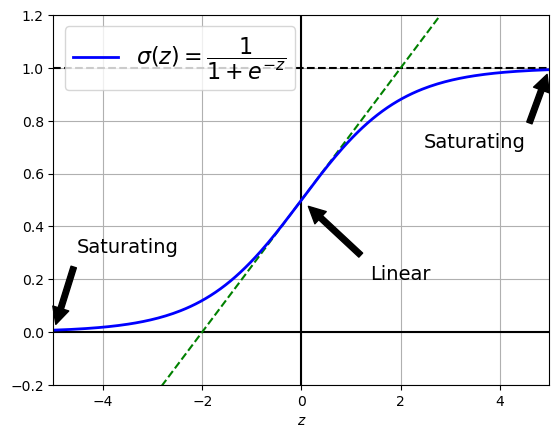

In [3]:
# Sigmoid Activation Function saturation:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16);

### A.1. Glorot and He Initialization:

* To alleviate the unstable gradients problem, the signal needs to flow properly in both directions: In the forward direction when making predictions, and in the reverse direction when backpropagating gradients.
    * The signal should not die out, nor explode and saturate. For the signal to flow properly:
        * The variance of the outputs of each layer should be equal to the variance of the inputs.
        * The gradients needs to have equal variance before and after flowing through a layer in the reverse direction.
    * It is actually not possible to guarantee both unless the layer has an equal number of inputs and outputs (*fan-in* and *fan-out* of the layer), but *Glorot* and *Bengio* proposed a good compromise:
        * The connection weights of each layer must be initialized randomly, **Glorot Initialization or Xaviar Initialization**: <br>
        &emsp; *when using the sigmoid activation function* <br>
        &emsp; Normal distribution w/ mean, $\mu$=0 and variance ,$\sigma^2=\frac{1}{fan_{avg}}$ <br>
        &emsp; Uniform distribution between $-r$ and $+r$, w/ $r\ =\ \sqrt{\frac{3}{fan_{avg}}}$ <br>
        &emsp; where $fan_{avg}\ =\ \frac{fan_{in}\ +\ fan_{out}}{2}$
        * Using Glorot Initialization can speed up training considerably.

    * **LeCun Initialization**:
        * Is equivalent to Glorot initialization when $fan_{in}\ =\ fan_{out}$

* Initialization parameters for each type of activation function: <br><br>
    &emsp; 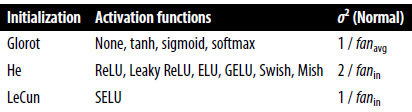

* By default, `Keras` uses Glorot initialization w/ a uniform distribution.
    * When creating a layer, you can switch to *He Initialization* by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"`.
    * Alternatively, other initialization techniques can be obtained using the `VarianceScaling` initializer.

In [4]:
dense = tf.keras.layers.Dense(
    50,
    activation="relu",
    kernel_initializer="he_normal"
)

In [5]:
# Using the VarianceScaling class : Creating He Initialization w/ uniform distribution and based on fan_avg
he_avg_init = tf.keras.initializers.VarianceScaling(
    scale=2,
    mode="fan_avg", 
    distribution="uniform"
)

dense = tf.keras.layers.Dense(
    50,
    activation="sigmoid",
    kernel_initializer=he_avg_init
)

### A.2. Better Activation Functions:

* Poor choice of activation functions leads to unstable gradients.
* Other activation functions behave much better in deep neural networks, in particular the ReLU activation fuction, mostly because it does not saturate for positive values, and also because it is very fast to compute. Unfortunately, the ReLU suffers from a problem known as the *dying ReLUs*:
    * During training, some neurons effectively die. They stop outputting anything other than 0. In some cases, half of the network's neurons are dead, especially if you used a large learning rate.
    * A neuron dies when its weights get tweaked in such a way that the input of the ReLU is negative for all instances in the training set. When this happens, it just keeps outputting zeros, and gradient descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.
        * A dead neuron may come back to life if its inputs evolve over time and eventually return w/in a range where the ReLU activation function gets a positive input again. For example, this may happen if gradient descent tweaks the neurons in the layers below the dead neuron.
    * Using a variant of the ReLU function, such as leaky ReLU, can solve this problem.

### Leaky ReLU

* $LeakyReLU_{\alpha}(z)\ =\ max(\alpha z, z)$ : <br>
    * $\alpha$ = This hyperparameter defines how much the function leaks: it is the slope of the function for $z < 0$.
        * Having a slope for $z < 0$ ensures that leaky ReLUs never die.
    * Leaky Variants always outperformed the strict ReLU activation function.
        * Setting $\alpha\ =\ 0.2$ (large leak) seemed to result in better performance than $\alpha\ =\ 0.01$ (small leak).
    * Randmized Leaky ReLU (RReLU):
        * $\alpha$ is picked randomly in a given range during training and is fixed to an average during test.
        * Act as a regularizer, reducing the risk of overfitting the training set.
    * Parametric Leaky ReLU (PReLU):
        * $\alpha$ is authorized to be learned during training: instead of being a hyperparameter. It becomes a parameter that can be modified by backpropagation like any other parameter.
        * Strongly outperform ReLU on large image datasets, but on small dataset it runs the risk of overfitting the training set.

* ReLU, Leaky ReLU, and PReLU all suffer from the fact that they are not smooth functions:
    * Their derivatives abruptly change (at z = 0).
    * This sort of discontinuity can make gradient descent bounce around the optimum, and slow down convergence.

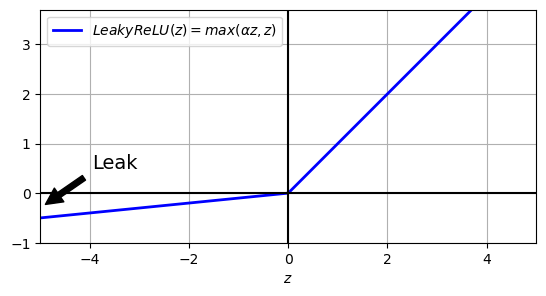

In [6]:
# Leaky ReLU 
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend();

In [9]:
# implementing leaky rely in keras
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
dense = tf.keras.layers.Dense(
    50,
    activation=leaky_relu,
    kernel_initializer="he_normal"
)

In [10]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

In [11]:
# implementing PRelu in keras
parametric_relu = tf.keras.layers.PReLU()
dense = tf.keras.layers.Dense(
    50,
    activation=parametric_relu,
    kernel_initializer="he_normal"
)

In [13]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.PReLU(),  # activation as a separate layer
    # [...]  # more layers
])

### Exponential Linear Unit (ELU) and Scaled Exponential Linear Unit (SELU):

* Exponential Linear Unit (ELU):
    * ELU Activation Function: <br>
    &emsp; $ELU_{\alpha}(z)\ =\begin{dcases} \mathrm{\alpha(exp(z)-1)\ if\ z\ <\ 0} \\ \mathrm{z\ if\ z\ \geq\ 0} \\  \end{dcases}$ <br>
    * ELU takes on negative values when z<0, w/c allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem.
        * The hyperparameter $\alpha$ defines the opposite of the value that the ELU function approaches when $z$ is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter.
    * ELU has a nonzero gradient for z<0, w/c avoids the dead neurons problem.
    * If $\alpha$ is equal to 1 then the function is smooth everywhere, including around $z=0$, w/c helps speed up gradient descent since it does not bounce as much to the left and right of $z=0$.
    * `activation="elu"`, w/ `HE initialization`
    * Main drawback of ELU is that it is slower to compute than the ReLU function and its variants, due to the use of the exponential function. Its faster convergence rate during training may compensate for the slow computation, but still, at test time an ELU network will be a bit slower than a ReLU network.

* Scaled ELU (SELU):
    * Scaled variant of the ELU activation function (about 1.05 times ELU, using $\alpha\ \approx\ 1.67$).
    * `activation="selu"`.
    * If you build a neural network composed exclusively of a stack of dense layers (i.e., an MLP), and if all hidden layers use the SELU activation function, then the network will self-normalize: <br>
        * The output of each layer will tend to preserve a mean of 0 and a standard deviation of 1 during training, which solves the vanishing/exploding gradients problem.
    * For the self-normalization to happen:
        * The input features must be standardized: mean 0 and standard deviation 1.
        * Every hidden layer’s weights must be initialized using LeCun normal initialization. `kernel_initializer="lecun_normal"`
        * The self-normalizing property is only guaranteed with plain MLPs.
        * You cannot use regularization techniques like ℓ1 or ℓ2 regularization, max-norm, batch-norm, or regular dropout.

In [14]:
dense = tf.keras.layers.Dense(
    50,
    activation="elu",
    kernel_initializer="he_normal"
)

In [16]:
dense = tf.keras.layers.Dense(
    50,
    activation="selu",
    kernel_initializer="lecun_normal"
)

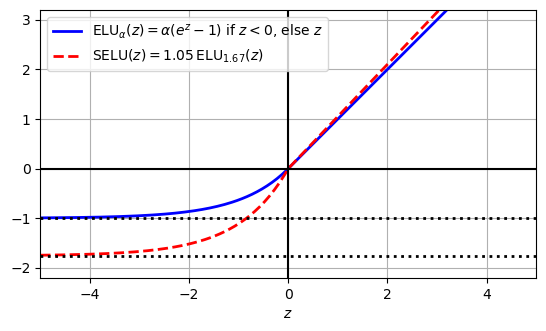

In [17]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend();